In [1]:
import pandas as pd 

filepath_dict = {'yelp':   './data/sentiment_analysis/yelp_labelled.txt',
                 'amazon': './data/sentiment_analysis/amazon_cells_labelled.txt',
                 'imdb':   './data/sentiment_analysis/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath,names=['sentence','label'], sep='\t')
    df['source'] = source # add another column with source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


One way you could do this is to count the frequency of each word in each sentence and tie this count back to the entire set of words in the data set. You would start by taking the data and creating a vocabulary from all the words in all sentences. The collection of texts is also called a corpus in NLP.

The vocabulary in this case is a list of words that occurred in our text where each word has its own index. This enables you to create a vector for a sentence. You would then take the sentence you want to vectorize, and you count each occurrence in the vocabulary. The resulting vector will be with the length of the vocabulary and a count for each word in the vocabulary. 

The resulting vector is also called a feature vector. In a feature vector, each dimension can be a numeric or categorical feature, like for example the height of a building, the price of a stock, or, in our case, the count of a word in a vocabulary. These feature vectors are a crucial piece in data science and machine learning, as the model you want to train depends on them.

In [2]:
sentences = ['John likes ice cream', 'John hates chocolate.']

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [4]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

Now, you can see the resulting feature vectors for each sentence based on the previous vocabulary. For example, if you take a look at the first item, you can see that both vectors have a 1 there. This means that both sentences have one occurrence of John, which is in the first place in the vocabulary.

This is considered a Bag-of-words (BOW) model, which is a common way in NLP to create vectors out of text. Each document is represented as a vector. You can use these vectors now as feature vectors for a machine learning model. This leads us to our next part, defining a baseline model.

In [5]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [6]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

You can see that the resulting feature vectors have 750 samples which are the number of training samples we have after the train-test split. Each sample has 1714 dimensions which is the size of the vocabulary. Also, you can see that we get a sparse matrix. This is a data type that is optimized for matrices with only a few non-zero elements, which only keeps track of the non-zero elements reducing the memory load.

CountVectorizer performs tokenization which separates the sentences into a set of tokens as you saw previously in the vocabulary. It additionally removes punctuation and special characters and can apply other preprocessing to each word. If you want, you can use a custom tokenizer from the NLTK library with the CountVectorizer or use any number of the customizations which you can explore to improve the performance of your model.

In [7]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


In [8]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train,y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source,score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_dim = X_train.shape[1] # number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                25060     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train,y_train, epochs = 100, verbose=False, validation_data=(X_test,y_test), batch_size=10)

In [24]:
loss, accuracy = model.evaluate(X_train,y_train, verbose=False)
print('Training accuracy: {:.4f}'.format(accuracy))
loss, accuracy = model.evaluate(X_test,y_test, verbose=False)
print('Testing accuracy: {:.4f}'.format(accuracy))

Training accuracy: 1.0000
Testing accuracy: 0.7807


You can already see that the model was overfitting since it reached 100% accuracy for the training set. But this was expected since the number of epochs was fairly large for this model. However, the accuracy of the testing set has already surpassed our previous logistic Regression with BOW model, which is a great step further in terms of our progress.

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


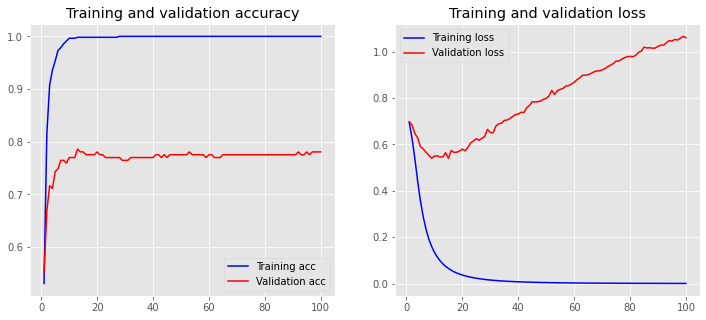

In [25]:
plot_history(history)

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


In [31]:
for word in ['the', 'all', 'good', 'bad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27
good: 33
bad: 30


Note: Pay close attention to the difference between this technique and the X_train that was produced by scikit-learn’s CountVectorizer.

With CountVectorizer, we had stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). With Tokenizer, the resulting vectors equal the length of each text, and the numbers don’t denote counts, but rather correspond to the word values from the dictionary tokenizer.word_index

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number.

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           128750    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


You can now see that we have 87350 new parameters to train. This number comes from vocab_size times the embedding_dim. These weights of the embedding layer are initialized with random weights and are then adjusted through backpropagation during training.

Training Accuracy: 1.0000
Testing Accuracy:  0.6738


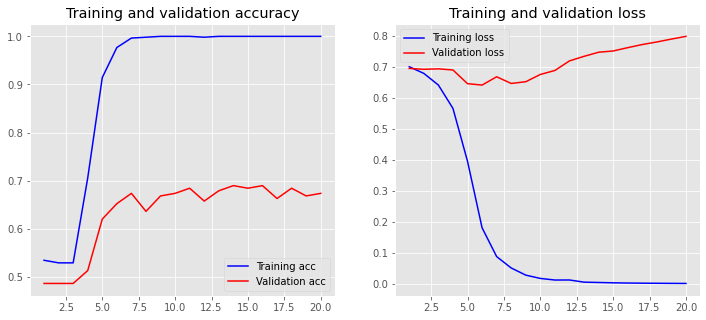

In [34]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

This is typically a not very reliable way to work with sequential data as you can see in the performance. When working with sequential data you want to focus on methods that look at local and sequential information instead of absolute positional information.

Another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding. You can think of the pooling layers as a way to downsample (a way to reduce the size of) the incoming feature vectors

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7433


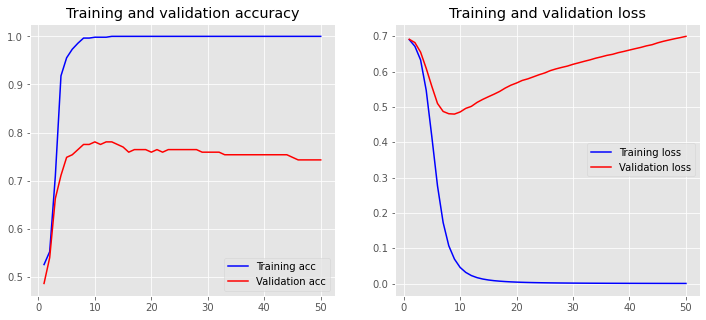

In [36]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


An alternative is to use a precomputed embedding space that utilizes a much larger corpus. It is possible to precompute word embeddings by simply training them on a large corpus of text. Among the most popular methods are Word2Vec developed by Google and GloVe (Global Vectors for Word Representation) developed by the Stanford NLP Group

In [37]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [44]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('./glove/glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

In [45]:
# First, let’s have a quick look how many of the embedding vectors are nonzero
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9522330097087378

In [46]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 521
Non-trainable params: 128,750
_________________________________________________________________


Training Accuracy: 0.7683
Testing Accuracy:  0.7594


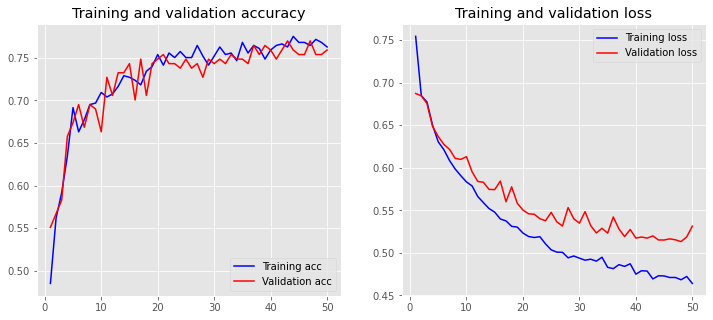

In [47]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Since the word embeddings are not additionally trained, it is expected to be lower. But let’s now see how this performs if we allow the embedding to be trained by using trainable=True:

In [48]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7861


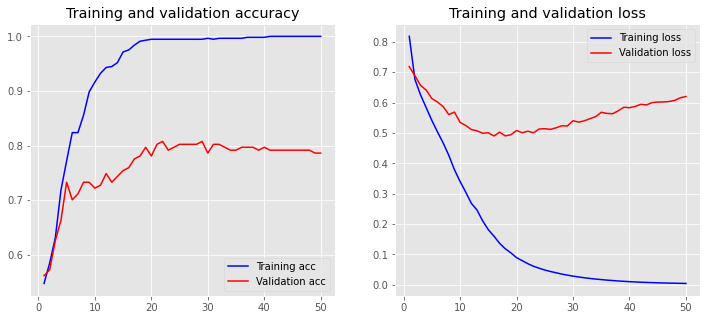

In [49]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Convolutional Neural Networks

In [50]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          257500    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7754


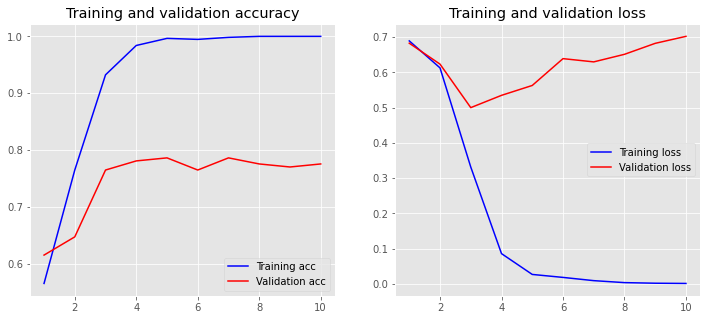

In [51]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Hyperparameters Optimization

In [52]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [53]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.3min finished


finished amazon; write to file and proceed? [y/n] y


Running amazon data set
Best Accuracy : 0.8098
{'vocab_size': 4603, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8355


Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.2min finished


finished imdb; write to file and proceed? [y/n] y


Running imdb data set
Best Accuracy : 0.8239
{'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8282


Running grid search for data set : yelp
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
